In [1]:
import torch
import numpy as np
from tfrecord.torch.dataset import TFRecordDataset
from torch.utils.data import Dataset, DataLoader
import tfrecord

import os
from os import path as osp
from tqdm.auto import tqdm
import deepdish as dd
import math
from typing import Dict

import matplotlib.pyplot as plt

In [2]:
# important global vars

FEATURES = ['elevation', 'chili', 'impervious', 'water', 
            'population', 'fuel1', 'fuel2', 'fuel3', 'NDVI', 
            'pdsi', 'pr', 'erc', 'bi', 'avg_sph', 'tmp_day', 
            'tmp_75', 'gust_med', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust']

FIRE_MASKS = ['viirs_PrevFireMask', 'viirs_FireMask']

### Visualization functions

In [3]:
def plot_dict_grid(info,ind = 0):
    n = len(info)
    
    # Calculate grid dimensions
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)
    
    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    # fig.suptitle('Grid Plot of Dictionary Items', fontsize=16)
    
    # If there's only one subplot, wrap it in a list for consistency
    if n == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    # Plot each item
    for ax, (key, value) in zip(axs, info.items()):
        value = value[ind].reshape((64,64))
        im = ax.imshow(value, cmap='viridis')
        # print(key,np.mean(value))
        ax.set_title(key)
        # ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Remove any unused subplots
    for i in range(n, len(axs)):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

#### File reading utils

In [4]:
def get_filenames(dirname = 'ndws_western_dataset'):
    # get names of train/test set
    filenames = []
    for fname in os.listdir(dirname):
        prefix = fname.split('_')[0]
        try:
            if fname[-1] == 'd' and 'cleaned' not in fname:
                filenames.append(osp.join(dirname,fname))
        except KeyError:
            continue
    return filenames

def write_tensor_dict_to_tfrecord(tensor_dict: Dict[str, torch.Tensor], filename: str) -> None:
    """
    Write a dictionary of PyTorch tensors to a TFRecord file, maintaining batch structure.
    Each item in the batch becomes its own TFRecord example.
    
    Args:
        tensor_dict: Dictionary where keys are feature names and values are torch tensors of shape (B,C)
        filename: Path to save the TFRecord file
    """
    writer = tfrecord.TFRecordWriter(filename)
    
    # Get batch size from first tensor
    batch_size = next(iter(tensor_dict.values())).shape[0]
    
    # Process each example in the batch
    for i in range(batch_size):
        example_dict = {}
        
        for key, tensor in tensor_dict.items():
            # Move to CPU if needed
            if tensor.is_cuda:
                tensor = tensor.cpu()
            
            # Get i-th example
            example_data = tensor[i].detach().numpy()
            
            # Determine dtype
            if np.issubdtype(example_data.dtype, np.integer):
                dtype = "int"
            elif np.issubdtype(example_data.dtype, np.floating):
                dtype = "float"
            else:
                dtype = "byte"
                
            # Convert to list format
            if dtype in ["int", "float"]:
                example_dict[key] = (example_data.tolist(), dtype)
            else:
                example_dict[key] = ([example_data.tobytes()], dtype)
        
        # Write this example
        writer.write(example_dict)
    
    writer.close()

def clean_data(file,min_detects = 5,max_impervious = 25):

    file_info = file.split('/')
    file_info[-1] = 'cleaned_' + file_info[-1]
    new_file = osp.join(*file_info)
    # print(new_file)
    # return
    if osp.exists(new_file):
        print("File already created.")
        return
    
    data_keys = FEATURES + FIRE_MASKS
    print("Cleaning file",file)
    dataset = TFRecordDataset(file,None)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64)
    
    filtered_data = {elem:[] for elem in data_keys}
    print("Filtering data...")
    for batch in tqdm(loader):
    
        if list(batch.keys()) != data_keys:
            # in this case, some data is missing
            continue
        
        # filtered for size of detects
        prev_fire_detects = torch.sum(batch['viirs_PrevFireMask'],axis = -1)
        post_fire_detects = torch.sum(batch['viirs_FireMask'],axis = -1)
        mask = (prev_fire_detects > min_detects) & (post_fire_detects > min_detects)
    
        # filtered for large urban areas
        impervious = torch.mean(batch['impervious'],axis = -1)
        mask = mask & (impervious < max_impervious)
    
        for feature in data_keys:
            filtered = batch[feature][mask]
            filtered_data[feature].append(filtered)

    # place into correct structure
    for feature in filtered_data:
        try:
            filtered_data[feature] = torch.cat(filtered_data[feature],axis = 0)
        except RuntimeError:
            print("This file has been completely filtered, with no valid data remaining.")
            return

    print("Writing a new TFrecord file...")

    write_tensor_dict_to_tfrecord(filtered_data,new_file)

### examine dataset

In [5]:
filenames = get_filenames()

for file in tqdm(filenames):
    try:
        clean_data(file,
                   min_detects = 5,
                   max_impervious=25,
                  )
    except:
        print("Issue encountered with file",file)

  0%|          | 0/60 [00:00<?, ?it/s]

Cleaning file ndws_western_dataset/test_ndws_conus_western_012.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_013.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_000.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_001.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_000.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_001.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_005.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_004.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_023.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_022.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_017.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_016.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_017.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_016.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_002.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_003.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_024.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_008.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_009.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_010.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_011.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_010.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_011.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_015.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_014.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_007.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_006.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_007.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_006.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_014.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_015.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_014.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_015.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_006.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_007.tfrecord
Filtering data...


0it [00:00, ?it/s]

Issue encountered with file ndws_western_dataset/test_ndws_conus_western_007.tfrecord
Cleaning file ndws_western_dataset/train_ndws_conus_western_020.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_021.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_003.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_002.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_003.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_002.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_011.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_010.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_009.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_008.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_009.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_008.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_004.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_005.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_004.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_005.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_016.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_013.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_012.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_013.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/eval_ndws_conus_western_012.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_019.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/train_ndws_conus_western_018.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_001.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...
Cleaning file ndws_western_dataset/test_ndws_conus_western_000.tfrecord
Filtering data...


0it [00:00, ?it/s]

Writing a new TFrecord file...


### Load and aggregate dataset-level statistics

In [10]:
filenames = {x:[] for x in ['train','test','eval']}
for mode in filenames:
    for x in os.listdir('ndws_western_dataset'):
        if x[-1] == 'd' and mode in x:
            filenames[mode].append(osp.join('ndws_western_dataset',x))

In [12]:
clipping_dict = {
    'elevation':(-10,6500),
    'chili':(0,255),
    'impervious':(0,100),
    'water':(0,100),
    'population':(0,810694),
    'fuel1':(-1e6,1e6),
    'fuel2':(-1e6,1e6),
    'fuel3':(-1e6,1e6),
    'NDVI':(-2000,10000),
    'pdsi':(-15,15),
    'pr':(0,690),
    'erc':(0,132),
    'bi':(0,215),
    'avg_sph':(0,0.02),
    'tmp_day':(-43,43),
    'tmp_75':(-43,43),
    'gust_med':(0,60),
    'wind_avg':(0,43),
    'wind_75':(0,43),
    'wdir_wind':(-np.pi,np.pi),
    'wdir_gust':(-np.pi,np.pi),
    'viirs_PrevFireMask':(0,1),
}

In [15]:
for mode in ['train','test','eval']:

    feature_stats = {x:{'min':float('inf'),'max':-float('inf'),'mean':[],'var':[]} for x in FEATURES}
    firemask_stats = {x:{'num_fire':0} for x in FIRE_MASKS}
    
    batches_per_file = []
    
    files_w_missing_features = []
    
    for fname in tqdm(filenames[mode]):
        print(fname)
        dataset = TFRecordDataset(fname,None)
        loader = torch.utils.data.DataLoader(dataset, batch_size=32)
        batch_sizes = []
        batch_means = {x:[] for x in FEATURES}
        batch_vars = {x:[] for x in FEATURES}
        try:
            for batch in loader:
                batch_sizes.append(batch['chili'].shape[0])
                for feature in FEATURES:
                    data = batch[feature]

                    # clip data to reasonable ranges
                    data = torch.clamp(data,min = clipping_dict[feature][0],max = clipping_dict[feature][1])
                    
                    batch_min = torch.min(data).item()
                    feature_stats[feature]['min'] = min(feature_stats[feature]['min'],batch_min)
        
                    batch_max = torch.max(data).item()
                    feature_stats[feature]['max'] = max(feature_stats[feature]['max'],batch_max)
        
                    batch_mean = torch.mean(data).item()
                    batch_means[feature].append(batch_mean)
                    batch_var = torch.var(data).item()
                    batch_vars[feature].append(batch_var)
                    
                for mask in FIRE_MASKS:
                    data = batch[mask]
                    if 'modis' in mask:
                        num_fire = torch.sum(data > 6).item()
                    else:
                        num_fire = torch.sum(data > 0).item()
                    firemask_stats[mask]['num_fire'] += num_fire
        except KeyError:
            print("This filename is missing features:",fname)
            files_w_missing_features.append(fname)
    
        batch_sizes = np.array(batch_sizes)
        batch_means = {x:np.array(batch_means[x]) for x in batch_means}
        batch_vars = {x:np.array(batch_vars[x]) for x in batch_vars}
        
        batches_per_file.append(batch_sizes)
    
        # aggregate statistics over the file
        for feature in FEATURES:
    
            fname_mean = np.sum(batch_sizes*batch_means[feature])/np.sum(batch_sizes)
            feature_stats[feature]['mean'].append(fname_mean)
    
            fname_var = 1/np.sum(batch_sizes)*np.sum(batch_sizes*(batch_vars[feature] + (batch_means[feature]-fname_mean)**2))
            feature_stats[feature]['var'].append(fname_var) 
    
    # aggregate statistics over dataset
    for feature in tqdm(FEATURES):
        data_dict = feature_stats[feature]
        summed_batches= np.array([np.sum(x) for x in batches_per_file])
        
        fname_means = np.array(data_dict['mean'])
        feature_mean = 1/np.sum(summed_batches)*np.sum(summed_batches*fname_means)
        feature_stats[feature]['mean'] = feature_mean
    
        fname_vars = np.array(data_dict['var'])
        feature_var = 1/sum(summed_batches)*np.sum(summed_batches*(fname_vars + (fname_means-feature_mean)**2))
        feature_stats[feature]['var'] = feature_var   

    n_samples = sum([np.sum(x) for x in batches_per_file])
    firemask_stats['total_samples'] = n_samples

    feature_stats['clipping'] = clipping_dict
    
    feature_stats.update(firemask_stats)

    dd.io.save(f'data_statistics/ndws_western_{mode}_stats.h5',feature_stats)

  0%|          | 0/25 [00:00<?, ?it/s]

ndws_western_dataset/cleaned_train_ndws_conus_western_004.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_005.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_013.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_012.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_019.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_018.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_014.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_015.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_020.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_021.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_003.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_002.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_009.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_008.tfrecord
ndws_western_dataset/cleaned_train_ndws_conus_western_024.tfre

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

ndws_western_dataset/cleaned_test_ndws_conus_western_005.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_004.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_012.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_013.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_015.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_014.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_002.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_003.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_008.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_009.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_011.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_010.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_006.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_001.tfrecord
ndws_western_dataset/cleaned_test_ndws_conus_western_000.tfrecord
ndws_weste

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

ndws_western_dataset/cleaned_eval_ndws_conus_western_000.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_001.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_007.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_006.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_010.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_011.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_003.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_002.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_009.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_008.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_012.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_004.tfrecord
ndws_western_dataset/cleaned_eval_ndws_conus_western_005.tfrecord


  0%|          | 0/21 [00:00<?, ?it/s]

In [16]:

stat_files = {'train': 'data_statistics/ndws_western_train_stats.h5',
              'test': 'data_statistics/ndws_western_test_stats.h5',
              'eval': 'data_statistics/ndws_western_eval_stats.h5'}
mode = 'train'
info = dd.io.load(stat_files[mode])

In [20]:
info['viirs_PrevFireMask']['num_fire']/(info['total_samples']*4096)

0.03384930928548177

### visualize data

In [80]:
dirname = 'ndws_west_coast_dataset'

filenames = {x:[] for x in ['train','test','eval']}
for mode in filenames:
    for x in os.listdir(dirname):
        if x[-1] == 'd' and mode in x:
            filenames[mode].append(osp.join(dirname,x))

In [91]:
file = filenames['train'][4]
print(file)
dataset = TFRecordDataset(file,None)
loader = torch.utils.data.DataLoader(dataset, batch_size=32)
info = next(iter(loader))

ndws_west_coast_dataset/cleaned_train_ndws_conus_007.tfrecord


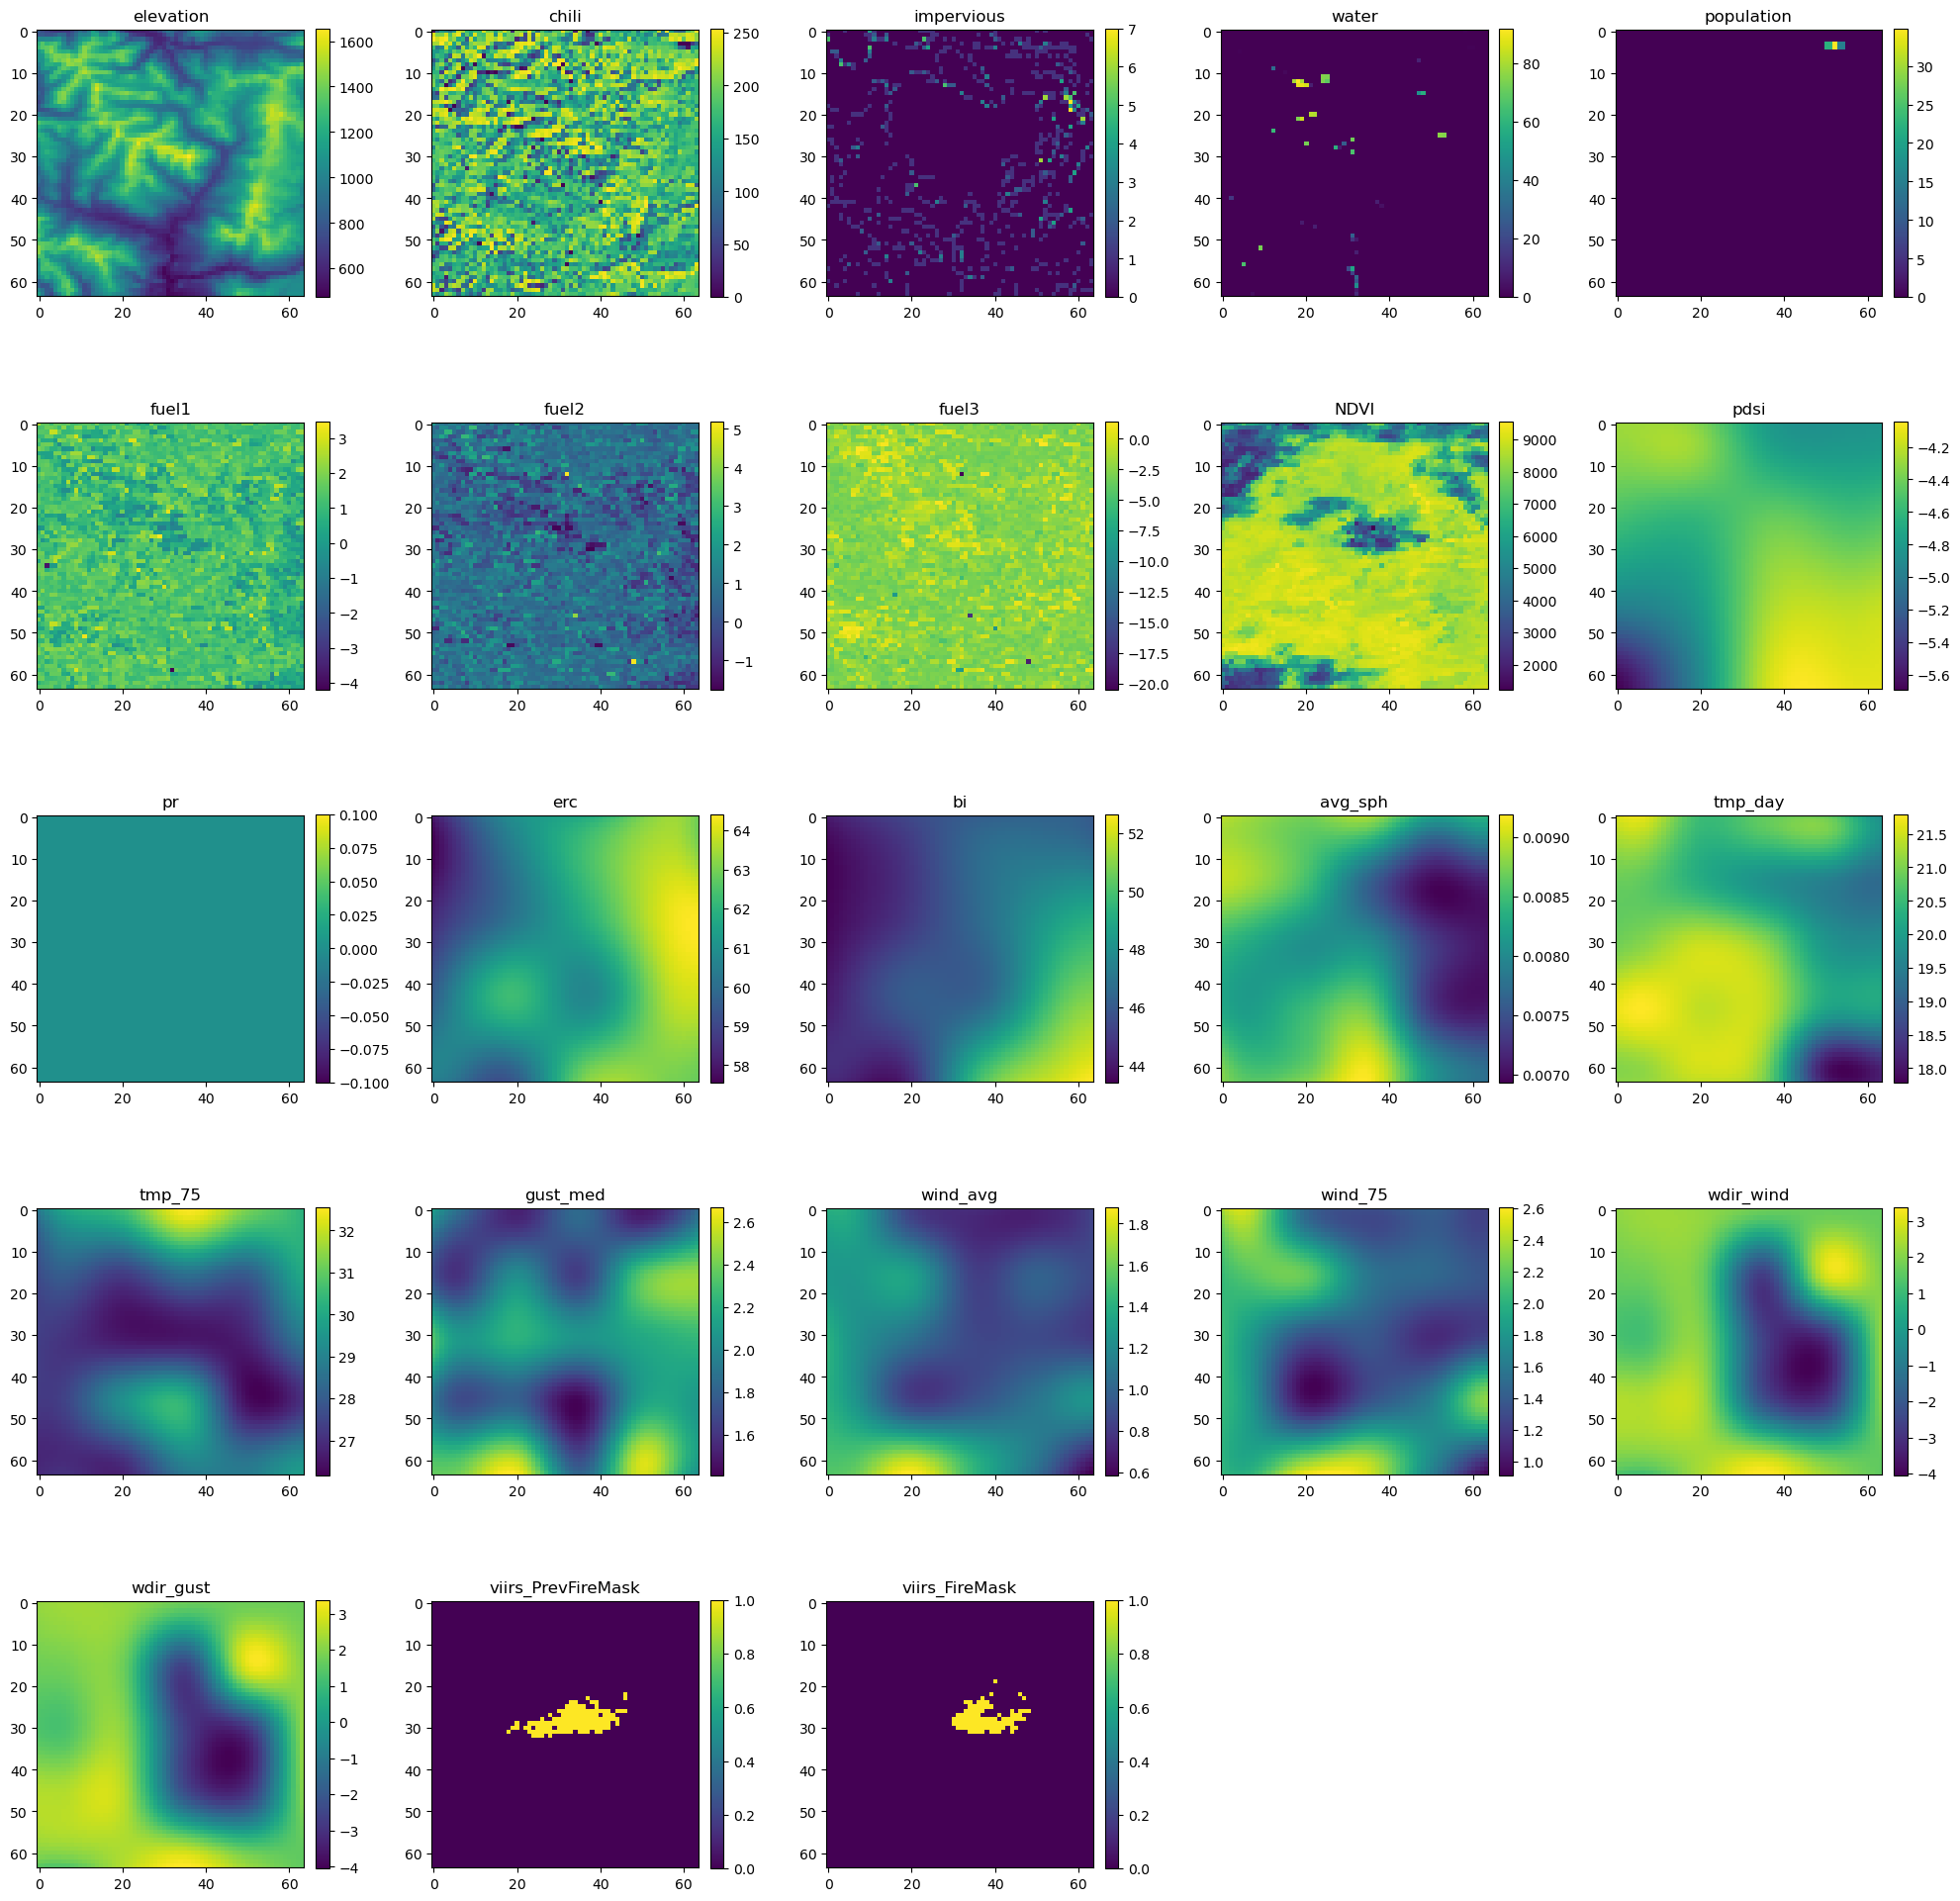

In [88]:
plot_dict_grid(batch,23)

### Create nicer visualization

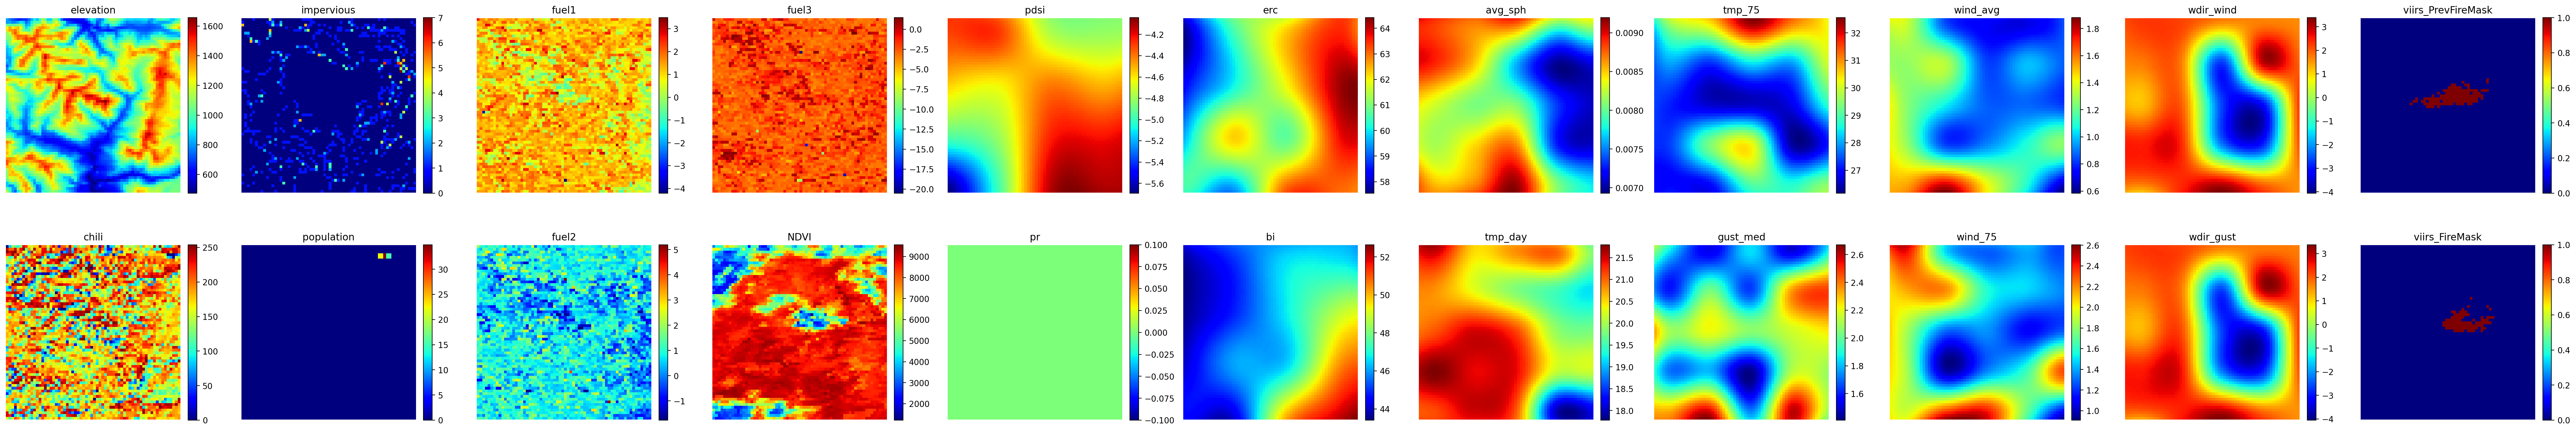

In [101]:
ind = 23
n = len(info)
# Calculate grid dimensions
cols = 11
rows = 2
    
# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows),dpi = 200)
# fig.suptitle('Grid Plot of Dictionary Items', fontsize=16)

axs = axs.T.flatten()

# del info['water'] # removing water as it's probably not useful and helps with viz
    
# Plot each item
for ax, (key, value) in zip(axs, info.items()):
    if key == 'water':
        continue
    value = value[ind].reshape((64,64))
    im = ax.imshow(value, cmap='jet')
    # print(key,np.mean(value))
    ax.set_title(key)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
# # Remove any unused subplots
# for i in range(n, len(axs)):
#     fig.delaxes(axs[i])

plt.tight_layout()
plt.savefig("dataset_example.jpg")
plt.show()